\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

# 1. {-}

Read in the data and drop the ```id``` and ```bond_id``` columns which clearly have no predictive power. Those columns that have "type" in the column name and the ```is_callable``` column are categorical variables which should be converted into dummy variables. Any other columns are on ratio scale. There are 46 of them. After the conversion, including the dummy variables, there are 69 predictors in the data (note that the response ```trade_price``` is also in the data now). We then add a constant column with value 1 for intercept in the regression. 

In [1]:
import pandas as pd

data = pd.read_csv('bonddata.txt', sep=',').drop(['bond_id', 'id'], axis='columns')

# categorical
catCols = ['is_callable'] + [col for col in data.columns if 'type' in col]

# predictors on ratio scale
rsCols = [col for col in data.columns if col not in ['is_callable', 'trade_price'] and 'type' not in col]

data = pd.get_dummies(data=data, columns=catCols, drop_first=True)
data['constant'] = 1

print(len(rsCols))
print(data.shape)

46
(1620, 71)


Below we plot the histogram for the first few predictors that are on ratio scale. The skewness for some of the variables is clear

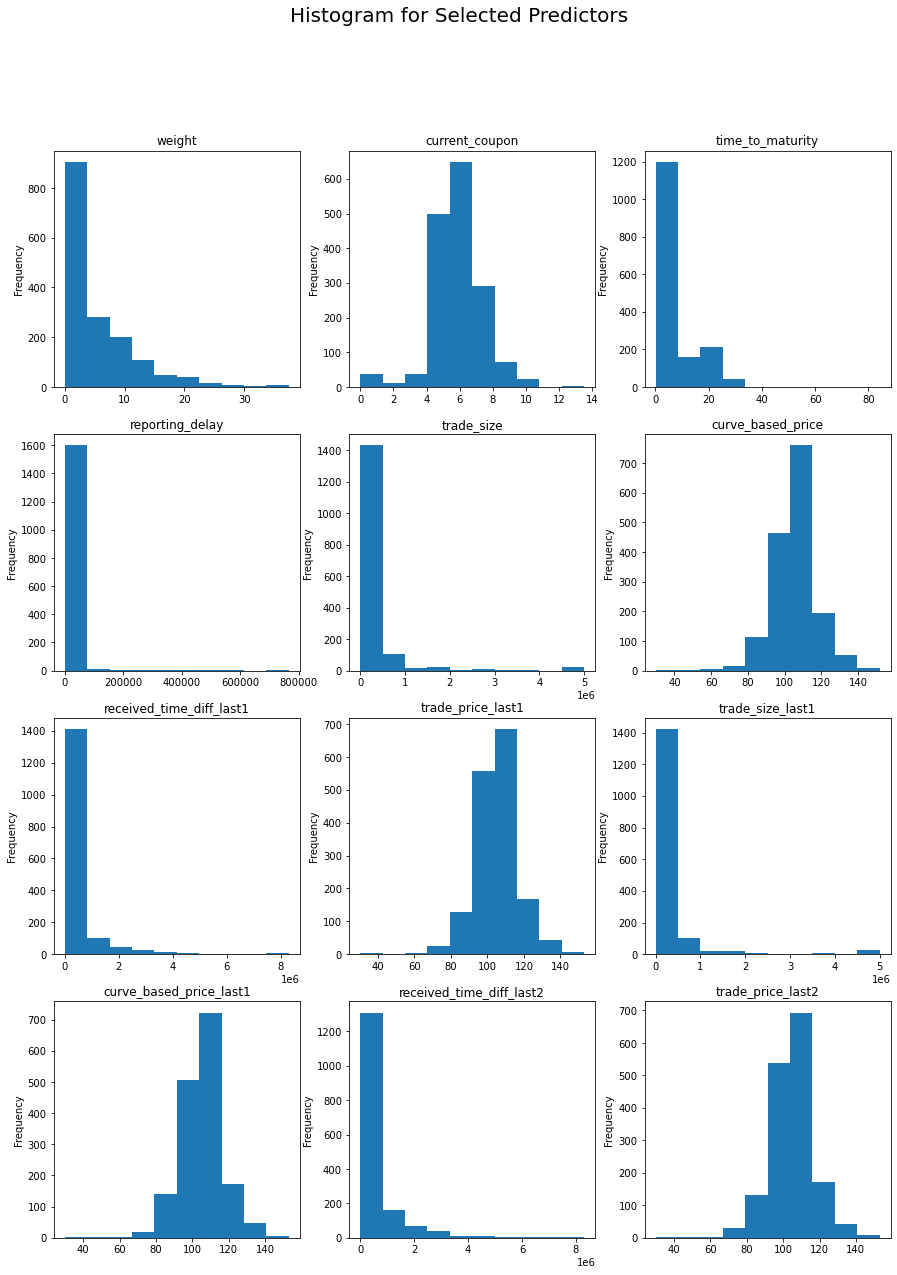

In [2]:
import matplotlib.pyplot as plt

def histplotGrid(suptitle):
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle(suptitle, size=20)

    for col, ax in zip(rsCols[:12], axs.flatten()):
        data[col].plot(kind='hist', ax=ax)
        ax.set_title(col)
        
histplotGrid('Histogram for Selected Predictors')

We then apply the Yeo-Johnson transformation on each of those 46 predictors. The ```trade_size``` columns and the ```received_time_diff``` columns have large values so a $\log(1+x)$ transformation is applied beforehand. The histogram of the first few predictors after transformation are shown below.

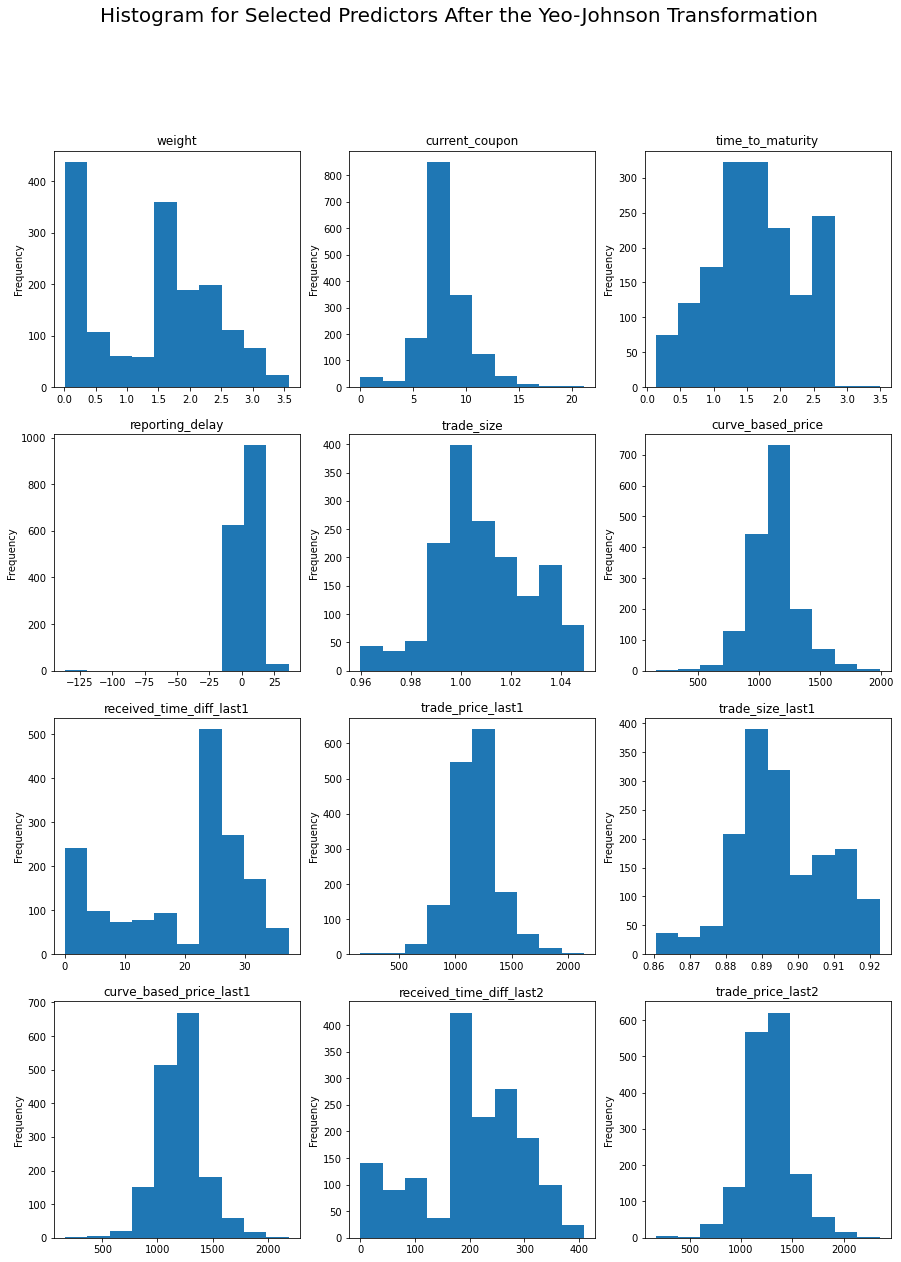

In [3]:
from scipy import stats
import numpy as np

lambdaDict = {}
for col in rsCols:
    if 'received_time_diff' in col or 'trade_size' in col:
        data[col] = np.log(data[col] + 1)
    data[col], lambdaDict[col] = stats.yeojohnson(data[col])

histplotGrid('Histogram for Selected Predictors After the Yeo-Johnson Transformation')

Convert all dummy variables to float so that rpy2 can work. 

In [4]:
for col in data.columns:
    if 'type' in col or 'is_callable' in col:
        data[col] = data[col].map(float)

The ```boxcox``` R procedure shows that the optimal $\lambda$ for the response is 1.6. 

In [5]:
import rpy2
%load_ext rpy2.ipython

[1] 1.59596


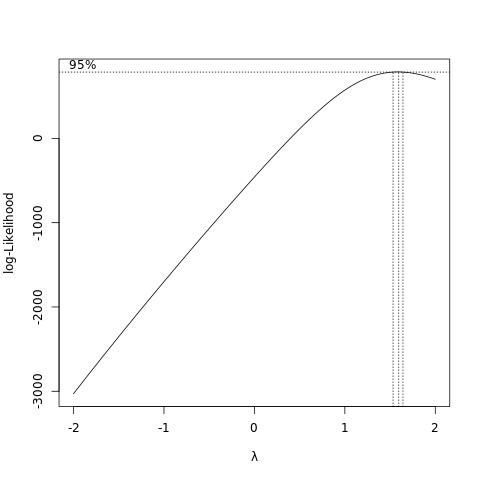

In [6]:
%%R -i data

library(MASS)
res = boxcox(trade_price~., data=data)
res$x[which(res$y==max(res$y))]

Now we fit the model $y^{1.6} = \sum\beta_i x_i$. Note that, with $\lambda=1.6$, the Box-Cox transformation $y^{(1.6)}$ is merely a linear function of $y^{1.6}$, so using either as the response is equivalent. Below are the diagnostic plots and a summary of the fitting results. 

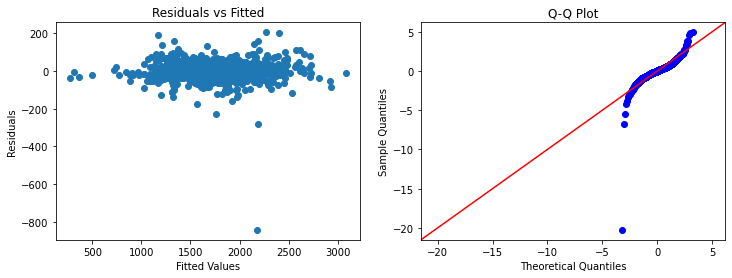

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            trade_price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1121.
Date:                Sun, 08 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:13:22   Log-Likelihood:                -8337.0
No. Observations:                1620   AIC:                         1.681e+04
Df Residuals:                    1550   BIC:                         1.719e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
weight                        4.3275      5.236      0.827      0.409      -5.942      14.597
current_coupon                0.4612      0.502      0.918      0.359      -0.524       1.447
time_to_maturity             -0.3372      1.870     -0.180      0.857      -4.005       3.331
reporting_delay              -0.6268      0.189     -3.325      0.001      -0.997      -0.257
trade_size                  413.2111     65.700      6.289      0.000     284.341     542.081
curve_based_price             0.5760      0.063      9.135      0.000       0.452       0.700
received_time_diff_last1     -0.2879      0.444     -0.649      0.516      -1.158       0.582
trade_price_last1             0.6073      0.053     11.540      0.000       0.504       0.711
trade_size_last1           -320.4019    117.097     -2.736      0.006    -550.088     -90.716
curve_based_price_last1       0.0080      0.094      0.085      0.932      -0.177       0.193
received_time_diff_last2     -0.0109      0.025     -0.439      0.660      -0.059       0.038
trade_price_last2             0.0474      0.052      0.911      0.363      -0.055       0.150
trade_size_last2             72.2001    134.662      0.536      0.592    -191.938     336.338
curve_based_price_last2      -0.0873      0.086     -1.015      0.310      -0.256       0.081
received_time_diff_last3      0.0067      0.010      0.709      0.478      -0.012       0.025
trade_price_last3             0.0711      0.056      1.277      0.202      -0.038       0.180
trade_size_last3            -67.0124    112.123     -0.598      0.550    -286.941     152.917
curve_based_price_last3      -0.1626      0.092     -1.766      0.078      -0.343       0.018
received_time_diff_last4     -0.0032      0.006     -0.505      0.613      -0.016       0.009
trade_price_last4             0.0984      0.042      2.332      0.020       0.016       0.181
trade_size_last4           -110.5800    120.450     -0.918      0.359    -346.843     125.683
curve_based_price_last4       0.2949      0.104      2.829      0.005       0.090       0.499
received_time_diff_last5     -0.0023      0.006     -0.398      0.691      -0.014       0.009
trade_price_last5             0.0872      0.063      1.393      0.164      -0.036       0.210
trade_size_last5            -33.9659     90.184     -0.377      0.707    -210.861     142.930
curve_based_price_last5      -0.4627      0.123     -3.759      0.000      -0.704      -0.221
received_time_diff_last6     -0.0016      0.006     -0.277      0.782      -0.013       0.010
trade_price_last6            -0.0471      0.041     -1.137      0.256      -0.128       0.034
trade_size_last6             59.3817     76.222      0.779      0.436     -90.127     208.891
curve_based_price_last6       0.2194      0.112      1.962      0.050    8.

In [7]:
import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot


model = sm.OLS(endog=(data['trade_price']**(1.6)), exog=data.drop('trade_price', axis='columns')).fit()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(model.fittedvalues, model.resid)
axs[0].set(title='Residuals vs Fitted', xlabel='Fitted Values', ylabel='Residuals')

qqplot(model.resid, dist=norm, line='45', fit=True, ax=axs[1])
axs[1].set(title='Q-Q Plot')

plt.show()
model.summary()

# 2. {-}

In [158]:
from scipy import stats
from scipy.optimize import minimize
import numpy as np
import numdifftools as nd


def treg(x, y):
    def neglogliketreg(params, x, y):
        beta0, beta1, sigma, nu = params
        resids = y - (x*beta1 + beta0)
        return (-1)*stats.t.logpdf(resids/sigma, nu).sum() + len(x)*np.log(sigma)
    
    holdcov = np.cov(x, y)
    beta1init = holdcov[0, 1]/holdcov[0, 0]
    beta0init = np.mean(y) - np.mean(x)*beta1init
    resids = y - (beta0init + beta1init*x)
    sigmainit = np.sqrt((resids**2).sum()/len(x))
    nuinit = 15
    
    mleout = minimize(neglogliketreg, [beta0init, beta1init, sigmainit, nuinit], args=(x, y), method='L-BFGS-B', bounds=[(None, None), (None, None), (0.001, None), (0.001, None)])
    hessfunc = nd.Hessian(neglogliketreg)
    
    return mleout.x, np.linalg.inv(hessfunc(mleout.x, x, y))

    
n = 10000
x = np.random.rand(n)
y = 4 + 5*x + 10*stats.t.rvs(20, size=n)
mle, var = treg(x, y)


from pandas import DataFrame
print(mle)
print(DataFrame(var))

[ 3.96950658  5.11496085  9.68153511 13.86651408]
          0         1         2         3
0  0.041971 -0.062786 -0.000074 -0.001422
1 -0.062786  0.125795  0.000136  0.002611
2 -0.000074  0.000136  0.012104  0.136060
3 -0.001422  0.002611  0.136060  2.891742


# 3. {-}

We will use ```scipy.optimize.minimize``` to find the MLE for Beta$(\alpha, \beta)$ numerically, with MOM estimators as the initial guess. Below we find the MOM estimators for Beta$(\alpha, \beta)$ first. 


Let $\hat m_1$ and $\hat m_2$ be the sample first and second moments, that is $\hat m_1 = \sum_{i=1}^n X_i/n$, $\hat m_2 = \sum_{i=1}^n X_i^2/n$. The MOM estimators $\hat\alpha_{\text{MOM}}$, $\hat\beta_{\text{MOM}}$ are the solution to the system of equations 
\begin{align*}
\begin{cases}
\hat m_1 &= \frac{\alpha}{\alpha + \beta}\\
\hat m_2 &= \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)} + \left(\frac{\alpha}{\alpha + \beta}\right)^2
\end{cases}, 
\end{align*}
where the right hand side are the first two moments of Beta$(\alpha, \beta)$. To solve the system, first note that $1-\hat m_1 = \beta/(\alpha + \beta)$ and hence
\begin{align*}
(\hat m_2 - \hat m_1^2)(\alpha + \beta + 1) = \frac{\alpha\beta}{(\alpha + \beta)^2} = \hat m_1(1-\hat m_1).
\end{align*}
Also from the first equation we have $\hat m_1(\alpha + \beta) = \alpha$. Thus we obtain a linear system of $\alpha$ and $\beta$: 
\begin{align*}
\begin{cases}
(\hat m_2 - \hat m_1^2)(\alpha + \beta + 1) &= \hat m_1(1-\hat m_1)\\
\hat m_1(\alpha + \beta) &= \alpha
\end{cases}. 
\end{align*}
A little algebra shows that the MOM estimators are
\begin{align*}
\hat\alpha_{\text{MOM}} &= \frac{\hat m_1^2(1 - \hat m_1)}{\hat m_2 - \hat m_1^2} - \hat m_1, \\
\hat\beta_{\text{MOM}} &= \frac{1-\hat m_1}{\hat m_1} \hat\alpha_{\text{MOM}}.
\end{align*}
These are the initial guess for the optimize procedure we will be using below. 


Below we define a function to compute the MLE and its variance numerically. 

In [6]:
from scipy.optimize import minimize
from scipy import stats
import numdifftools as nd
import numpy as np


def betamle(x):
    def negloglikelihood(params, x):
        a, b = params
        return (-1)*stats.beta.logpdf(x, a, b).sum()        
    
    m1 = x.mean()
    m2 = (x**2).mean()
    ahatmom = (m1**2)*(1-m1)/(m2-m1**2) - m1
    bhatmom = ahatmom*(1-m1)/m1

    mleout = minimize(negloglikelihood, [ahatmom, bhatmom], args=(x), method='L-BFGS-B', bounds=[(0.001, None), (0.001, None)])
    hessfunc = nd.Hessian(negloglikelihood)
    
    return mleout.x, np.linalg.inv(hessfunc(mleout.x, x))


Now we run simulation to confirm the above implementation is correct. First generate a sample of size 10,000 from the Beta$(5, 3)$ distribution. We see that the estimates by the above numerical procedure are quite close to the true values $\alpha=5, \beta=3$.

In [11]:
n = 10000
x = stats.beta(a=5, b=3).rvs(n)

mle, var = betamle(x)

print(mle)
print(var)

[5.00418234 3.01174226]
[[0.00489035 0.00249623]
 [0.00249623 0.00165838]]


Given the estimated covariance matrix of the MLE, the 95% confidence interval of both parameters can be found as below. 

In [12]:
z = stats.norm.ppf(1 - 0.025)

print('95% Confidence Interval for alpha: ', (mle[0] - z*np.sqrt(var[0][0]), mle[0] + z*np.sqrt(var[0][0])))
print('95% Confidence Interval for beta: ', (mle[1] - z*np.sqrt(var[1][1]), mle[1] + z*np.sqrt(var[1][1])))

95% Confidence Interval for alpha:  (4.867119992230483, 5.141244679178911)
95% Confidence Interval for beta:  (2.9319261522355946, 3.0915583756979492)


Finally we generate the confidence interval multiple times to confirm that 95% of the time the true vale of the parameters are covered. 

In [29]:
nSim = 1000

a = 5
b = 3
alphaCIs = []
betaCIs = []

for i in range(nSim):
    n = 10000
    x = stats.beta(a=a, b=b).rvs(n)
    mle, var = betamle(x)
    
    alphaCIs.append((mle[0] - z*np.sqrt(var[0][0]), mle[0] + z*np.sqrt(var[0][0])))
    betaCIs.append((mle[1] - z*np.sqrt(var[1][1]), mle[1] + z*np.sqrt(var[1][1])))

aInCI = sum([1 for l, r in alphaCIs if l<a<r])
bInCI = sum([1 for l, r in betaCIs if l<b<r])

print(f'{aInCI} out of {nSim} experiments generated a confidence interval that covers {a}')
print(f'{bInCI} out of {nSim} experiments generated a confidence interval that covers {b}')

947 out of 1000 experiments generated a confidence interval that covers 5
949 out of 1000 experiments generated a confidence interval that covers 3
